In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#importa sweetviz as vs

In [37]:
df_compl = pd.read_csv("Lending Club/loans_2007.csv")

/Users/kli/neuefische/13_Decision_trees/ds-ensemble-methods/.venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [38]:
df_compl.isnull().sum()

id                               0
member_id                        3
loan_amnt                        3
funded_amnt                      3
funded_amnt_inv                  3
term                             3
int_rate                         3
installment                      3
grade                            3
sub_grade                        3
emp_title                     2629
emp_length                    1115
home_ownership                   3
annual_inc                       7
verification_status              3
issue_d                          3
loan_status                      3
pymnt_plan                       3
purpose                          3
title                           16
zip_code                         3
addr_state                       3
dti                              3
delinq_2yrs                     32
earliest_cr_line                32
inq_last_6mths                  32
open_acc                        32
pub_rec                         32
revol_bal           

In [39]:
df_compl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42538 entries, 0 to 42537
Data columns (total 52 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          42538 non-null  object 
 1   member_id                   42535 non-null  float64
 2   loan_amnt                   42535 non-null  float64
 3   funded_amnt                 42535 non-null  float64
 4   funded_amnt_inv             42535 non-null  float64
 5   term                        42535 non-null  object 
 6   int_rate                    42535 non-null  object 
 7   installment                 42535 non-null  float64
 8   grade                       42535 non-null  object 
 9   sub_grade                   42535 non-null  object 
 10  emp_title                   39909 non-null  object 
 11  emp_length                  41423 non-null  object 
 12  home_ownership              42535 non-null  object 
 13  annual_inc                  425

In [40]:
# wir elimierniern drei übeltäter die voll mit nans sind in der zeile
rows_delete=df_compl[df_compl["loan_amnt"].isnull()].index


df_compl= df_compl.drop(rows_delete, axis=0)

In [41]:
####################################### Data cleaning
# emp_legth,home_ownership verdummien
# interaktionterm von annual income und verifications_status
# untersuchen ob zwischen 2007 und 2009 kreditausfälle stattgefunden haben durch die krise, varibale issue_d untersuchen
# loan_status zu einer neuen kategorievariable machen mit : 0 = gezahlt, 1= ausstehend, 2= nicht in der lage
# die, die wir rausgeschmissen haben, haben wir entweder nicht verstanden oder waren unbalancierte variablen 
# emp_length verdummien, da ca. 1100 fehlen

columns_useless =["id", "member_id", "pymnt_plan", "initial_list_status", "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq", "chargeoff_within_12_mths", "delinq_amnt", "tax_liens"]

columns_unwanted=["emp_title","title","zip_code", "addr_state","out_prncp","out_prncp_inv","total_pymnt","last_pymnt_amnt","last_pymnt_d","last_credit_pull_d"]

columns_50_50=["delinq_2yrs","earliest_cr_line","inq_last_6mths","pub_rec","revol_util","total_acc"]

# weitere features werden gelöscht aufgrund correlations
columns_corr=["funded_amnt","funded_amnt_inv","total_pymnt_inv"]

# weitere features werden gelöscht, da sie die selben infos tragen bzw. daraus werden unsere anderen variablen bestimmt
columns_sameinfo=["total_rec_int","total_rec_prncp","total_rec_late_fee", "recoveries","collection_recovery_fee"]

# hier wird das y, also unser target bestimmt
y_columns=["loan_status","grade","sub_grade"]

In [42]:
# hier wird das y, also unser target bestimmt
y_target=df_compl[y_columns]

#y_app= y_target["loan_status"].apply(lambda y: 1 if y == y_01[0] else 0)

<AxesSubplot:xlabel='total_acc', ylabel='loan_status'>

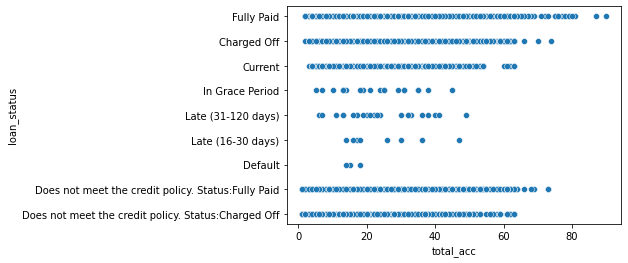

In [43]:
#df_compl.isnull().sum()
sns.scatterplot(x=df_compl["total_acc"], y=df_compl["loan_status"], markers = "count()")

In [44]:
#spalten löschen
df= df_compl.drop(columns_useless, axis=1).drop(columns_corr, axis=1).drop(columns_sameinfo, axis=1).drop(columns_unwanted, axis=1).drop(columns_50_50, axis=1).drop(y_columns, axis=1)

In [45]:
#### Hier werden die dateintypen, welche falsch sind korrigiert
if type(df["int_rate"][0])== type("str"): 
    df["int_rate"]=df["int_rate"].str.strip("%").astype("float")
else:
    print("Already a float")
    
if type(df["term"][0]) == type("str"): 
    df["term"]=df["term"].str.strip("months").astype("float")
else:
    print("Already a float")


In [46]:
#### hier wird eine dateityp zum zeitdatentyp geändert
df["issue_d"]= pd.to_datetime(df["issue_d"])

In [47]:
df["issue_d"]

0       2011-12-01
1       2011-12-01
2       2011-12-01
3       2011-12-01
4       2011-12-01
           ...    
42531   2007-06-01
42532   2007-06-01
42533   2007-06-01
42534   2007-06-01
42535   2007-06-01
Name: issue_d, Length: 42535, dtype: datetime64[ns]

In [48]:
import datetime

df['issue_d'] = pd.to_datetime(df["issue_d"], format="%Y-%M-%D")
df['issue_d'] = df['issue_d'].map(datetime.datetime.toordinal)


In [49]:
# hier werden die fehlenden daten durch wahrscheinliche daten ersetzt (mean,median,blaa)

df["open_acc"].fillna(df["open_acc"].median(),inplace=True)
df["annual_inc"].fillna(df["annual_inc"].median().round(2),inplace=True)
df["emp_length"].fillna("no info at all", inplace=True)
df["pub_rec_bankruptcies"].fillna(0.0, inplace=True)



In [50]:
df.corrwith(df["open_acc"])

loan_amnt               0.176513
term                    0.045604
int_rate                0.024668
installment             0.175336
annual_inc              0.168078
issue_d                 0.003994
dti                     0.297877
open_acc                1.000000
revol_bal               0.257767
pub_rec_bankruptcies    0.009570
dtype: float64

(10, 10)


<AxesSubplot:>

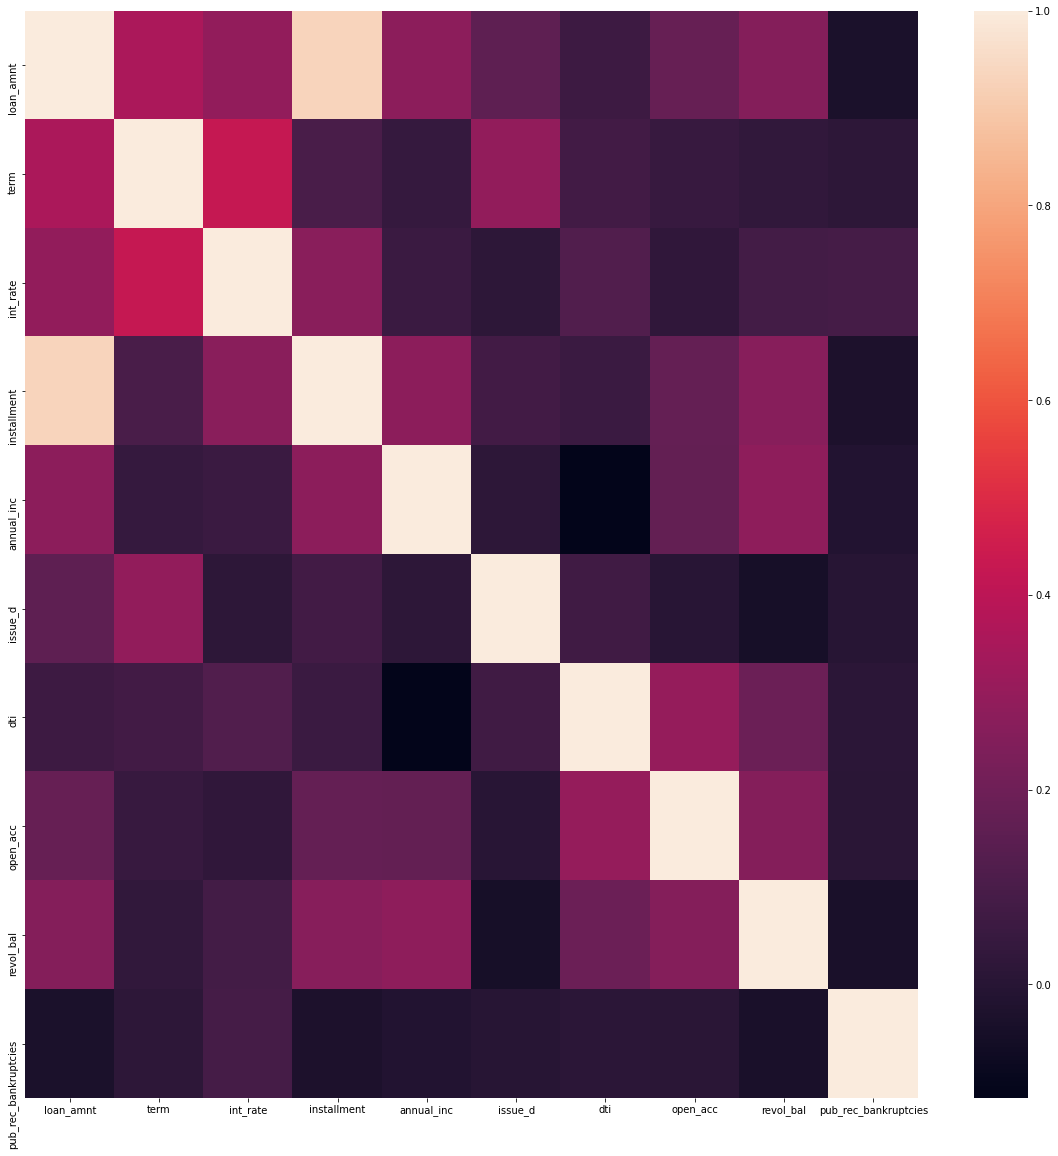

In [51]:
print(df.corr().shape)
fig= plt.figure(figsize=(20,20))
sns.heatmap(df.corr())

In [52]:
%store df y_target

Stored 'df' (DataFrame)
Stored 'y_target' (DataFrame)


In [35]:
### hier werden dummies erstellt

df_dummie=pd.get_dummies(df, drop_first=True)


df_y_sub_grade= pd.get_dummies(y_target["sub_grade"], drop_first=True)

In [540]:
y

0        1
1        0
2        1
3        1
4        0
        ..
42531    0
42532    0
42533    0
42534    0
42535    0
Name: loan_status, Length: 42535, dtype: int64

In [570]:
######### Modell
yy=y_target["loan_status"]
X= df_dummie

y_01= ["Fully Paid", "Charged Off"]
#y=y.apply(lambda y: 1 if y == y_01[1] else 0)
y= yy.apply(lambda y: 1 if y == y_01[0] else 0)

In [593]:
%store X y

Stored 'X' (DataFrame)
Stored 'y' (Series)


In [542]:
y.value_counts()

1    33136
0     9399
Name: loan_status, dtype: int64

In [543]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report


In [571]:
###### Naiv-estimator


# TODO: Total number of records
n_records = len(X)

# TODO: Number of records where individual's income is more than $50,000
fully_paid = y.sum()

# TODO: Number of records where individual's income is at most $50,000
charged_off = n_records - fully_paid

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = 100 * fully_paid / n_records

# Print the results
print ("Total number of records: {}".format(n_records))
print ("Individuals has paid her credit fully: {}".format(fully_paid))
print ("Individuals hasn't paid her credit: {}".format(charged_off))
print ("Percentage of individuals that paid ther credit: {:.2f}%".format(greater_percent))

Total number of records: 42535
Individuals has paid her credit fully: 33136
Individuals hasn't paid her credit: 9399
Percentage of individuals that paid ther credit: 77.90%


In [545]:
y.sum()

33136

In [584]:
#Split into train and test

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.4, random_state = 70, stratify= y)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 25521 samples.
Testing set has 17014 samples.


In [585]:
#### skalieren
from sklearn.preprocessing import MinMaxScaler


# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc',"issue_d","dti","open_acc","revol_bal","pub_rec_bankruptcies" ]
X_train[numerical] = scaler.fit_transform(X_train[numerical])
X_test[numerical] = scaler.transform(X_test[numerical])

# Show an example of a record with scaling applied
X_train[numerical].sample(1)

<ipython-input-585-3b240a593f72>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numerical] = scaler.fit_transform(X_train[numerical])
/Users/yusufcan/.pyenv/versions/3.8.5/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-585-3b240a593f72>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

loan_amnt  term  int_rate  installment  annual_inc  issue_d       dti  \
541   0.362319   0.0  0.581594     0.343715    0.006697      1.0  0.430574   

     open_acc  revol_bal  pub_rec_bankruptcies  
541  0.069767   0.011454                   0.0

In [583]:
X_train

loan_amnt  term  int_rate  installment  annual_inc  issue_d    dti  \
17044    11000.0  60.0     10.74       237.75     42996.0   734228  12.14   
7043      5000.0  36.0      7.51       155.56     54080.0   734381   4.15   
18702    14500.0  36.0      7.29       449.65     52000.0   734197  26.47   
10921     8000.0  36.0      8.49       252.51    115000.0   734319   4.50   
42180    13000.0  36.0     17.22       286.10     36000.0   733011  23.47   
...          ...   ...       ...          ...         ...      ...    ...   
28813    12000.0  36.0      7.88       375.38     54996.0   733924  18.79   
39757    20000.0  36.0     13.43       678.08    145000.0   732889  10.15   
35797     8000.0  36.0     13.16       270.17     50000.0   733620   9.96   
24028     6000.0  60.0      6.54       117.51     30000.0   734077  11.00   
7981      3300.0  36.0      5.99       100.38     30000.0   734381  11.04   

       open_acc  revol_bal  pub_rec_bankruptcies  ...  \
17044       5.0      139.0                   0.0  ...   
7043        8.0      941.0                   0.0  ...   
18702      11.0    19113.0                   0.0  ...   
10921      16.0    15384.0                   0.0  ...   
42180       8.0    10130.0                   0.0  ...   
...         ...        ...                   ...  ...   
28813      19.0     9994.0                   0.0  ...   
39757      17.0    41674.0                   0.0  ...   
35797       5.0     3958.0                   0.0  ...   
24028       6.0    11290.0                   0.0  ...   
7981        9.0    11144.0                   0.0  ...   

       purpose_home_improvement  purpose_house  purpose_major_purchase  \
17044                         1              0                       0   
7043                          0              0                       0   
18702                         0              0                       0   
10921                         0              0                       0   
42180                         0              0                       0   
...                         ...            ...                     ...   
28813                         0              0                       0   
39757                         0              0                       0   
35797                         0              0                       0   
24028                         0              0                       0   
7981                          1              0                       0   

       purpose_medical  purpose_moving  purpose_other  \
17044                0               0              0   
7043                 0               0              0   
18702                0               0              0   
10921                0               0              1   
42180                0               0              0   
...                ...             ...            ...   
28813                0               0              0   
39757                0               0              0   
35797                0               0              0   
24028                0               0              0   
7981                 0               0              0   

       purpose_renewable_energy  purpose_small_business  purpose_vacation  \
17044                         0                       0                 0   
7043                          0                       0                 0   
18702                         0                       0                 0   
10921                         0                       0                 0   
42180                         0                       0                 0   
...                         ...                     ...               ...   
28813                         0                       0                 0   
39757                         0                       0                 0   
35797                         0                       0                 0   
24028                         0                      

In [575]:
####fit von log reg

lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)
lr.score(X_train,y_train)

0.7888405626738764

In [497]:
#print(lr.coef_);
#print(lr.intercept_);

In [586]:
### predic

y_pred = lr.predict(X_test)

In [587]:
cm = confusion_matrix(y_test,y_pred)
print(cm)
cp= classification_report(y_test,y_pred)
print(cp)
#acs=accuracy_score((y_test,y_pred))
#print(acs)

[[  523  3237]
 [  384 12870]]
              precision    recall  f1-score   support

           0       0.58      0.14      0.22      3760
           1       0.80      0.97      0.88     13254

    accuracy                           0.79     17014
   macro avg       0.69      0.56      0.55     17014
weighted avg       0.75      0.79      0.73     17014



In [588]:
######## DecisionTree
dtc = DecisionTreeClassifier()

In [589]:
dtc.fit(X_train,y_train)


DecisionTreeClassifier()

In [591]:
y_pred_dtc=dtc.predict(X_test)

In [592]:
cm = confusion_matrix(y_test,y_pred_dtc)
print(cm)
cp= classification_report(y_test,y_pred_dtc)
print(cp)

[[ 1475  2285]
 [ 2505 10749]]
              precision    recall  f1-score   support

           0       0.37      0.39      0.38      3760
           1       0.82      0.81      0.82     13254

    accuracy                           0.72     17014
   macro avg       0.60      0.60      0.60     17014
weighted avg       0.72      0.72      0.72     17014

